In [3]:
import pandas as pd
import seaborn as sns
from glob import glob
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

In [5]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    mask_india = df["ADDRESS"].str.contains("Mumbai")
    mask_bhk = df["BHK_OR_RK"] == "BHK"
    mask_price = df["TARGET(PRICE_IN_LACS)"] < 1_000
    
    df = df[mask_india & mask_bhk & mask_price]
    
    return df

In [11]:
df = wrangle("/home/d3lia/Development/DataScience/House Price Prediction in India/Pred with size_location/Jupyter/Participants_Data_HPP/Train.csv")
df.head(10)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
23,Dealer,0,0,1,BHK,630.000630,1,1,"Bandra (West),Mumbai",19.054440,72.840560,300.0
43,Dealer,0,1,3,BHK,1274.924779,1,1,"Marol,Mumbai",22.803593,83.755013,250.0
66,Dealer,0,1,3,BHK,1038.883942,1,1,"Powai,Mumbai",19.120000,72.910000,280.0
84,Dealer,0,1,2,BHK,1004.932182,1,1,"New Panvel,Mumbai",18.966114,73.148278,81.5
131,Dealer,0,1,2,BHK,1294.016156,1,1,"4 Bunglows,Mumbai",19.128324,72.825408,330.0
140,Dealer,0,0,2,BHK,890.045187,1,1,"Sector-25 Khandeshhwar,Mumbai",28.582887,77.339935,65.0
145,Dealer,0,0,3,BHK,1740.139211,1,1,"Sector 19 Kharghar,Mumbai",19.048979,73.078232,180.0
173,Dealer,0,0,2,BHK,1210.136674,1,1,"Kamothe,Mumbai",19.016800,73.096460,85.0
174,Dealer,0,0,2,BHK,1365.001365,1,1,"Sector-11 Ghansoli,Mumbai",19.126499,72.999560,200.0
185,Dealer,1,0,1,BHK,448.531061,0,1,"Kanjur Marg (East),Mumbai",19.221571,73.042474,120.0


In [14]:
df.select_dtypes("object").nunique()

POSTED_BY      3
BHK_OR_RK      1
ADDRESS      382
dtype: int64

<Axes: >

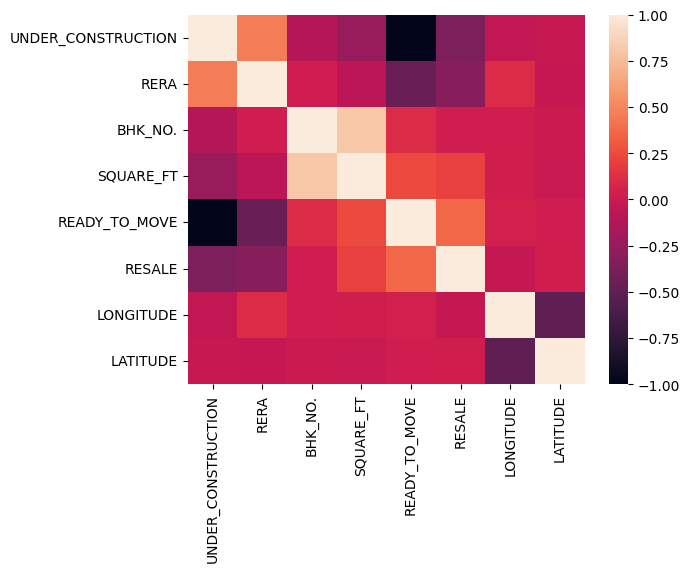

In [15]:
corr = df.select_dtypes("number").drop(columns="TARGET(PRICE_IN_LACS)").corr()
sns.heatmap(corr)

In [16]:
target = "TARGET(PRICE_IN_LACS)"
features = ["SQUARE_FT", "LATITUDE", "LONGITUDE"]
y_train = df[target]
X_train = df[features]

In [17]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean BHK price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean BHK price: 170.55
BAseline MAE: 104.89722805256201


In [18]:
model = make_pipeline(
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('ridge', Ridge())])

In [19]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 70.45192974665427


In [21]:
X_test = pd.read_csv("/home/d3lia/Development/DataScience/House Price Prediction in India/Pred with size_location/Jupyter/Participants_Data_HPP/Test.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0     58.126960
1    113.573888
2    193.557218
3    235.457101
4     33.114559
dtype: float64

In [22]:
def make_prediction(area, lat, lon):
    data = {
        "SQUARE_FT": area,
        "LATITUDE": lat,
        "LONGITUDE": lon
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted BHK price: {prediction} LACS"

In [24]:
interact(
    make_prediction,
    area=IntSlider(
        min = X_train["SQUARE_FT"].min(),
        max = X_train["SQUARE_FT"].max(),
        value = X_train["SQUARE_FT"].mean(),
    ),
    lat=FloatSlider(
        min = X_train["LATITUDE"].min(),
        max = X_train["LATITUDE"].max(),
        step = 0.01,
        value = X_train["LATITUDE"].mean(),
    ),
    lon=FloatSlider(
        min = X_train["LONGITUDE"].min(),
        max = X_train["LONGITUDE"].max(),
        step = 0.01,
        value = X_train["LONGITUDE"].mean(),
    )
);

interactive(children=(IntSlider(value=1063, description='area', max=5670, min=225), FloatSlider(value=72.04620…